In [1]:
!pip3 install saxpy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [3]:
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

dat = df1['L_T1'].values

amount_of_levels = 3
window_size = 2

discrete_signal = []
for t in range(len(dat)-window_size):
    dat_znorm = znorm(dat[t:t+window_size])
    discrete_signal.append(ts_to_string(dat_znorm, cuts_for_asize(amount_of_levels)))
    

In [4]:
## Count the occurences of different words
word_counts = pd.Series(discrete_signal).value_counts()

['ca', 'ca', 'bb', 'ac', 'ac']


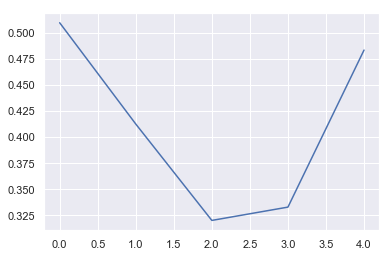

In [5]:
## Show example:
print(discrete_signal[0:5])
sns.lineplot(data=dat[0:5])

In [6]:
## Create a string out of it:
ts_string = " ".join(discrete_signal)

In [7]:
import nltk
from nltk import bigrams
from nltk import trigrams


In [8]:
## Creating tokens and do n-gram stuff

tokens = nltk.word_tokenize(ts_string)
bi_tokens = bigrams(tokens)
tri_tokens = trigrams(tokens)
fdist = nltk.FreqDist(tri_tokens)
trigram_df = pd.DataFrame.from_dict(fdist.items())

ValueError: DataFrame constructor not properly called!

In [9]:
trigram_df.sort_values(1, ascending=False)

NameError: name 'trigram_df' is not defined

In [14]:
pd.DataFrame.from_dict(fdist.items())

ValueError: DataFrame constructor not properly called!